In [1]:
import copy
import numpy as np
from matplotlib import pyplot as plt
from common.baseclasses import AWA
from importlib import reload
from common import numerical_recipes as numrec
from common.numerical_recipes import QuickConvolver,smooth
import EigenProbe as EP
TM=EP #legacy naming support
from NearFieldOptics import Materials as M

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/alexandersmcleod/tools/python/common/baseclasses.py:473: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  try: result=ndarray_operator(self,*args,**kwargs)
/Users/alexandersmcleod/tools/python/common/baseclasses.py:482: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in

# Build Simulation

In [2]:
#--- Build rectangular laplacian with edge for graphene (particle-in-box planewaves)
N=300
L=200 #We will deal in units of tip radius, so this will be a 6 micron (or so) view
Nq=2000

#--- Build homogeneous laplacian operator just to get its basis for the substrate (periodic plane waves)
Substrate=TM.SubstrateDielectric(Lx=L,Nx=N,Ly=L,Nqmax=Nq)
X,Y=Substrate.XY
dx=np.diff(Substrate.xy[0])[0]

#--- Build ribbon graphene
Rx=0.8*L
Dx=(L-Rx)/2
Graphene=TM.S.SpectralLaplacian_ribbon(Lx=L,Nx=N,Ly=L,Nqmax=Nq,Rx=Rx,x0=Dx)

Generating eigenpairs on x,y=[-100.0:+100.0:300],[-100.0:+100.0:300]
	Time elapsed: 3.327735662460327
Generating eigenpairs on x,y=[-100.0:+100.0:300],[-100.0:+100.0:300]
	Time elapsed: 4.1550610065460205


## Build domain wall

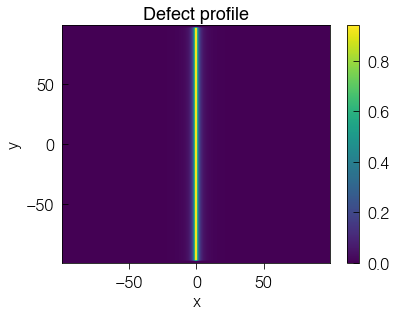

In [3]:
#--- Build inhomogeneous conductivity
defectw=2*dx
#defect_profile=(np.abs(X)<5*dx) #ribbon
defect_profile=defectw**2/(X**2+defectw**2)
d=3 #This is somehow necessary to make it a normal operator
defect_profile[:d]=0
defect_profile[-d:]=0
defect_profile[:,:d]=0
defect_profile[:,-d:]=0

Defect=TM.S.GridLaplacian_aperiodic(dx,sigma=defect_profile)

plt.figure()
AWA(defect_profile,adopt_axes_from=Substrate.AWA).real.plot()
plt.title('Defect profile');

## Construct photonic system

In [4]:
Q=20
PS=TM.Photonic2DSystem(Substrate,(Graphene,Defect),
                         beta_substrate=0.5,lambdap=20,sigmas2D=[1-1j/Q]*2,PML_amplitude=10,\
                         Nbasis=2000)

Constructing augmented basis with 2D materials...
Finding augmented basis by QR decomposition...
	Removed 862 redundant vectors.
	Time elapsed: 104.68828320503235
Building Laplacian operator in augmented basis...
Building 2993x1900 inner product matrix...
	Time elapsed: 4.342088937759399
Building 2993x1955 inner product matrix...
	Time elapsed: 4.544837236404419
Diagonalizing new Hermitian operator of size (2993, 2993)...
	Time elapsed: 17.928847312927246
	Time elapsed: 32.914090394973755
Filtered 428 eigenpairs.
Filtered 564 eigenpairs.
Size of composite laplacian: 2002
Projecting operator 1 onto basis...
Building 2002x1900 inner product matrix...
	Time elapsed: 3.135939121246338
Projecting operator 2 onto basis...
Computing aperiodic Laplacian...
	Time elapsed: 20.470551252365112
Building 2002x2002 inner product matrix...
	Time elapsed: 10.428798913955688
Projecting operator 3 onto basis...
Building 2002x2002 inner product matrix...
	Time elapsed: 3.606924057006836
Projecting operato

# Look at sample response

In [5]:
#--- This is just a dipole, emulating the field from a tip

def excitation(Rx,Ry,a=1):
    
    direction=[0,1]
    z=5*a #This gives a qpeak=1/(2*z)=1/(10a) (Jiang & Fogler) and lambda_peak=2*pi*10a
    r=np.sqrt(Rx**2+Ry**2+z**2)
    rho=np.sqrt(Rx**2+Ry**2)
    rhat_rho=rho/r
    rhat_z=z/r

    exc=(direction[0]*rhat_rho+direction[1]*rhat_z)/r**2
    
    return AWA(exc,adopt_axes_from=Substrate.AWA)

## Real-space response to excitation

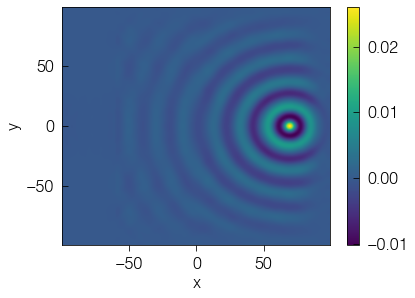

In [6]:
plt.figure()
PS.set_PML_amplitude(1)
PS.set_Beta_substrate(.5)
PS.set_LambdaP(40)
PS(excitation(X-70,Y)).real.plot()

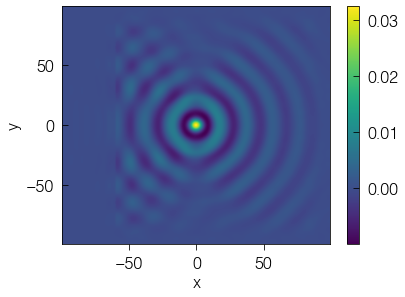

In [7]:
PS.set_PML_amplitude(1)
plt.figure()
PS(excitation(X,Y)).real.plot()

## Linescans versus $\lambda_p$

Projecting excitations...
	Time elapsed: 2.0404610633850098
Computing reflection matrix...
	Time elapsed: 4.250164985656738
Computing reflection coefficient


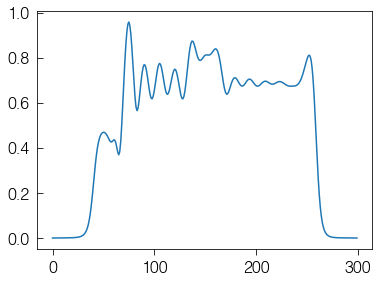

In [8]:
excs=[excitation(X-x0,Y) for x0 in PS.xy[0]]
Rs=PS.R(excs)
plt.figure()
plt.plot(np.abs(Rs))

wl= 10.0
Projecting excitations...
	Time elapsed: 2.06673002243042
Computing reflection matrix...
	Time elapsed: 4.64600396156311
Computing reflection coefficient
wl= 14.736842105263158
Projecting excitations...
	Time elapsed: 2.2607858180999756
Computing reflection matrix...
	Time elapsed: 5.240891933441162
Computing reflection coefficient
wl= 19.473684210526315
Projecting excitations...
	Time elapsed: 2.4129459857940674
Computing reflection matrix...
	Time elapsed: 4.676805734634399
Computing reflection coefficient
wl= 24.210526315789473
Projecting excitations...
	Time elapsed: 2.4587807655334473
Computing reflection matrix...
	Time elapsed: 5.463132858276367
Computing reflection coefficient
wl= 28.94736842105263
Projecting excitations...
	Time elapsed: 2.724653720855713
Computing reflection matrix...
	Time elapsed: 5.3751890659332275
Computing reflection coefficient
wl= 33.68421052631579
Projecting excitations...
	Time elapsed: 2.798825979232788
Computing reflection matrix...
	Time 

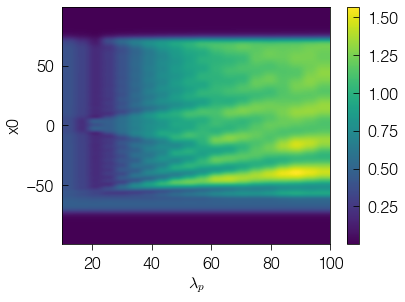

In [9]:
excs=[excitation(X-x0,Y) for x0 in PS.xy[0]]
PS.set_PML_amplitude(1)

wls=np.linspace(10,100,20)

linescans=[]
for wl in wls:
    print('wl=',wl)
    PS.set_LambdaP(wl)
    linescans.append(PS.R(excs))
    
linescans=AWA(linescans,axes=[wls,PS.xy[0]],axis_names=['$\lambda_p$','x0'])

plt.figure()
np.abs(linescans).plot()